In [1]:
import pandas as pd
cat_directory = 'E:\\seismic wave detection\\space_apps_2024_seismic_detection\\data\\lunar\\training\\catalogs\\'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

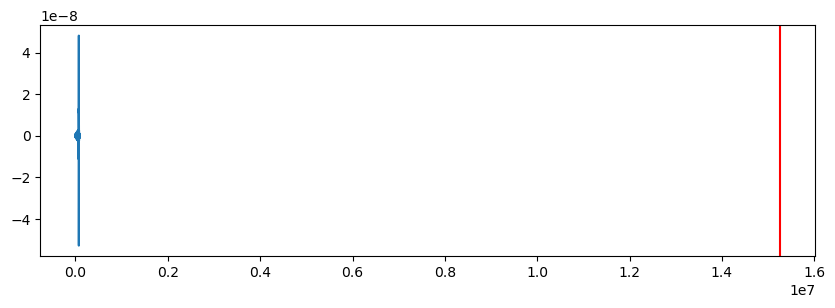

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

row = cat.iloc[6]  # Example: selecting the 7th event
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
test_filename = row['filename']

data_directory = 'E:\\seismic wave detection\\space_apps_2024_seismic_detection\\data\\lunar\\training\\data\\S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)

# Plotting
csv_times = np.array(data_cat['time_rel(sec)'])
csv_data = np.array(data_cat['velocity(m/s)'])
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(csv_times, csv_data)
ax.axvline(x=arrival_time.timestamp(), color='red', label='Arrival Time')
plt.show()


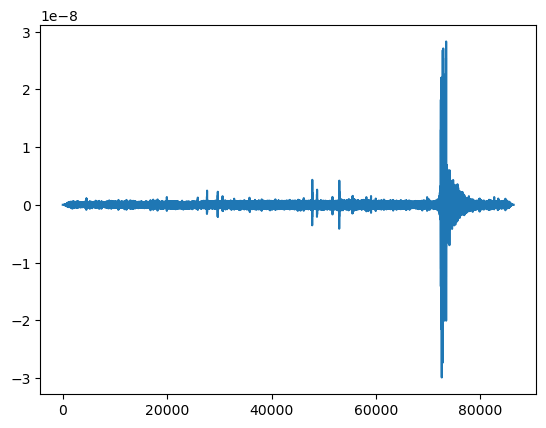

In [3]:
from obspy.signal.filter import bandpass

st_filt = bandpass(data=csv_data, freqmin=0.01, freqmax=0.5, df=6.625)  # Apply filter
plt.plot(csv_times, st_filt)
plt.show()


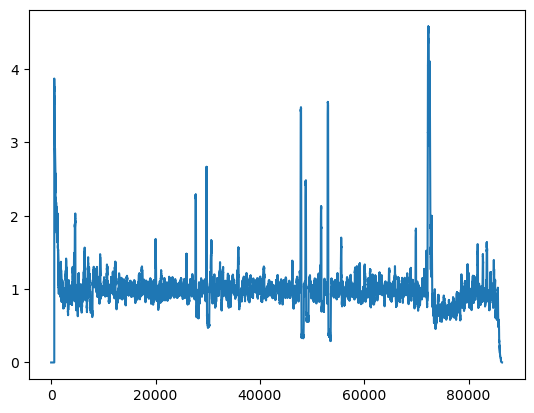

In [4]:
from obspy.signal.trigger import classic_sta_lta

sta_len = 120  # Short-term window in seconds
lta_len = 600  # Long-term window in seconds
df = 6.625  # Sampling rate

# Run STA/LTA
cft = classic_sta_lta(csv_data, int(sta_len * df), int(lta_len * df))

# Plot
plt.plot(csv_times, cft)
plt.show()

In [5]:
# Check for missing values
print(data_cat.isnull().sum())

# Remove rows with missing values
data_cleaned = data_cat.dropna()


time_abs(%Y-%m-%dT%H:%M:%S.%f)    0
time_rel(sec)                     0
velocity(m/s)                     0
dtype: int64


In [6]:
from scipy.signal import resample

# Resample to a fixed number of points (e.g., 1000 points)
num_samples = 1000
csv_data_resampled = resample(csv_data, num_samples)
csv_times_resampled = np.linspace(min(csv_times), max(csv_times), num_samples)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
csv_data_normalized = scaler.fit_transform(csv_data.reshape(-1, 1)).flatten()


In [8]:
from obspy.signal.filter import bandpass

# Apply bandpass filter between 0.01 Hz and 0.5 Hz
minfreq = 0.01
maxfreq = 0.5
csv_data_filtered = bandpass(csv_data, freqmin=minfreq, freqmax=maxfreq, df=6.625)


In [9]:
window_size = 10  # Adjust window size based on data needs
csv_data_smoothed = np.convolve(csv_data_filtered, np.ones(window_size)/window_size, mode='valid')


In [10]:
from scipy.signal import detrend

csv_data_detrended = detrend(csv_data_filtered)


In [11]:
amplitude = np.max(np.abs(csv_data_detrended))  # Max amplitude
energy = np.sum(np.square(csv_data_detrended))  # Energy of the signal


In [12]:
window_size = 1000  # Adjust based on your data
num_windows = len(csv_data_detrended) // window_size

for i in range(num_windows):
    window_data = csv_data_detrended[i*window_size : (i+1)*window_size]
    # Process window_data here


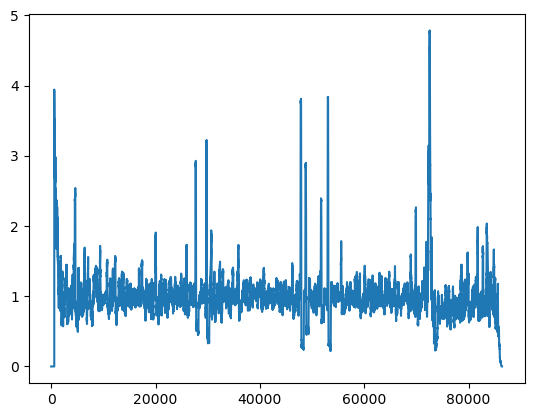

In [13]:
from obspy.signal.trigger import classic_sta_lta

# STA/LTA parameters
sta_len = 120  # Short-term window in seconds
lta_len = 600  # Long-term window in seconds
df = 6.625  # Sampling rate

# Run STA/LTA
cft = classic_sta_lta(csv_data_detrended, int(sta_len * df), int(lta_len * df))

# Plot the characteristic function to identify seismic events
plt.plot(csv_times, cft)
plt.show()


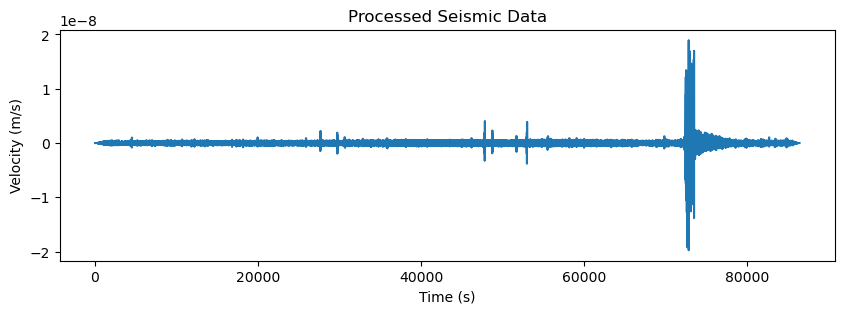

In [14]:
plt.figure(figsize=(10, 3))
plt.plot(csv_times[:len(csv_data_smoothed)], csv_data_smoothed)
plt.title('Processed Seismic Data')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.show()


In [15]:
sta_len = 120  # Short-term window in seconds
lta_len = 600  # Long-term window in seconds
df = 6.625  # Sampling rate (Hz)

# Compute STA/LTA characteristic function
cft = classic_sta_lta(csv_data_detrended, int(sta_len * df), int(lta_len * df))

# Define a threshold for detecting seismic waves
threshold = 2.5  # Example threshold value

# Label the data based on STA/LTA threshold
# If STA/LTA > threshold, label as 1 (seismic wave); otherwise, 0 (no wave)
labels = np.where(cft > threshold, 1, 0)

# Now you have the labels array, where each value corresponds to whether a seismic wave was detected
print(labels)

[0 0 0 ... 0 0 0]


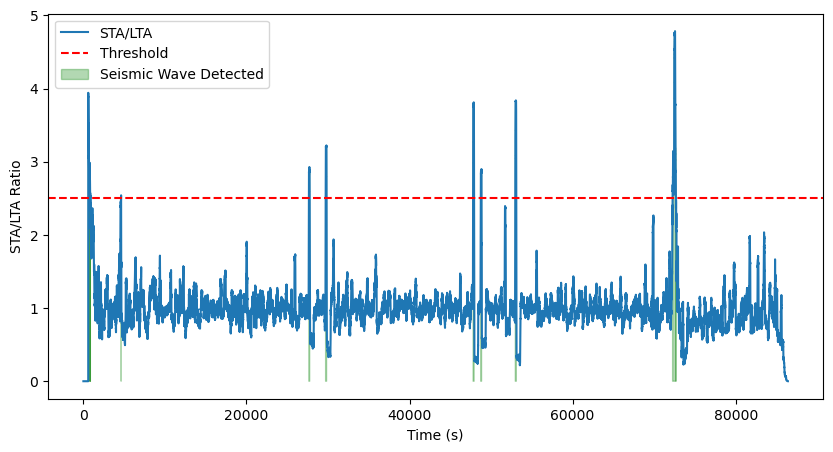

In [16]:
# Plot STA/LTA characteristic function with threshold and labels
plt.figure(figsize=(10, 5))
plt.plot(csv_times[:len(cft)], cft, label='STA/LTA')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.fill_between(csv_times[:len(cft)], 0, cft, where=(cft > threshold), color='green', alpha=0.3, label='Seismic Wave Detected')
plt.xlabel('Time (s)')
plt.ylabel('STA/LTA Ratio')
plt.legend()
plt.show()


In [17]:
# Add labels to your DataFrame
data_cat['label'] = np.pad(labels, (0, len(data_cat) - len(labels)), 'constant')  # Padding in case labels are shorter than the data

# Now, you can use 'data_cat' for training your machine learning models
print(data_cat[['time_rel(sec)', 'velocity(m/s)', 'label']].head())


   time_rel(sec)  velocity(m/s)  label
0       0.000000  -6.727977e-16      0
1       0.150943  -8.646711e-16      0
2       0.301887  -9.298738e-16      0
3       0.452830  -8.589095e-16      0
4       0.603774  -7.139047e-16      0


In [18]:
import numpy as np
import pandas as pd
from obspy.signal.trigger import classic_sta_lta
from sklearn.model_selection import train_test_split


           mean           std           max           min        energy  \
0 -7.003167e-15  6.552952e-13  2.921779e-12 -2.834701e-12  4.294608e-22   
1 -1.288154e-14  6.790912e-12  3.239916e-11 -2.453911e-11  4.611665e-20   
2 -1.372693e-13  1.730155e-11  6.558788e-11 -8.167763e-11  2.993625e-19   
3  1.162694e-13  4.258040e-11  1.387427e-10 -1.323714e-10  1.813104e-18   
4 -5.840086e-13  6.474986e-11  1.866771e-10 -2.350287e-10  4.192886e-18   

      amplitude  label  
0  2.921779e-12      0  
1  3.239916e-11      0  
2  8.167763e-11      0  
3  1.387427e-10      0  
4  2.350287e-10      1  
Shape of X: (572, 6), Shape of y: (572,)


In [20]:
# Assuming csv_data_detrended and csv_times are defined
window_size = 1000  # Size of each window in data points
num_windows = len(csv_data_detrended) // window_size

# Function to extract features from each window
def extract_features(window_data):
    features = {}
    features['mean'] = np.mean(window_data)
    features['std'] = np.std(window_data)
    features['max'] = np.max(window_data)
    features['min'] = np.min(window_data)
    features['energy'] = np.sum(window_data ** 2)
    features['amplitude'] = np.max(np.abs(window_data))
    return features

features_list = []
labels_list = []

# Define STA/LTA parameters
sta_len = 120  # Short-term window in seconds
lta_len = 600  # Long-term window in seconds
df = 6.625  # Sampling rate
threshold = 1.5  # Define a threshold for detecting seismic events

# Calculate the STA/LTA characteristic function
cft = classic_sta_lta(csv_data_detrended, int(sta_len * df), int(lta_len * df))

# Loop through the data windows
for i in range(num_windows):
    # Extract a window of data
    window_data = csv_data_detrended[i * window_size:(i + 1) * window_size]
    
    # Extract features for the window
    features = extract_features(window_data)
    features_list.append(features)

    # Label the window based on STA/LTA threshold
    # We will check the characteristic function value at the center of the window
    center_index = (i * window_size) + (window_size // 2)
    if center_index < len(cft) and cft[center_index] > threshold:
        labels_list.append(1)  # Label as seismic wave
    else:
        labels_list.append(0)  # Label as no seismic wave

# Convert lists of dictionaries to a DataFrame
features_df = pd.DataFrame(features_list)

# Add labels to the features DataFrame
features_df['label'] = labels_list

# Check the first few rows of the resulting DataFrame
print(features_df.head())

# Now let's split the data into training and test sets
X = features_df.drop('label', axis=1)  # Feature matrix
y = features_df['label']                 # Labels

# Check the shapes of X and y before splitting
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

           mean           std           max           min        energy  \
0 -7.003167e-15  6.552952e-13  2.921779e-12 -2.834701e-12  4.294608e-22   
1 -1.288154e-14  6.790912e-12  3.239916e-11 -2.453911e-11  4.611665e-20   
2 -1.372693e-13  1.730155e-11  6.558788e-11 -8.167763e-11  2.993625e-19   
3  1.162694e-13  4.258040e-11  1.387427e-10 -1.323714e-10  1.813104e-18   
4 -5.840086e-13  6.474986e-11  1.866771e-10 -2.350287e-10  4.192886e-18   

      amplitude  label  
0  2.921779e-12      0  
1  3.239916e-11      0  
2  8.167763e-11      0  
3  1.387427e-10      0  
4  2.350287e-10      1  
Shape of X: (572, 6), Shape of y: (572,)


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
X = features_df.drop(columns=['label'])  # Feature matrix without the label column
y = features_df['label']  # Binary labels (0 for no wave, 1 for wave)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model
svm_model = SVC(kernel='linear')  # You can change the kernel type if needed
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[164   0]
 [  8   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       164
           1       0.00      0.00      0.00         8

    accuracy                           0.95       172
   macro avg       0.48      0.50      0.49       172
weighted avg       0.91      0.95      0.93       172



C:\Users\LAYAP\miniconda3\envs\hands_on_ml\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LAYAP\miniconda3\envs\hands_on_ml\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LAYAP\miniconda3\envs\hands_on_ml\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [27]:
X_train.shape

(400, 6)

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [24]:
# List of classifiers to test
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Dictionary to store accuracies
accuracy_results = {}

# Train and evaluate each classifier
for name, model in classifiers.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results[name] = accuracy
    
    # Print results
    print(f"{name} Accuracy: {accuracy}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# Compare the results
print("\nComparison of Model Accuracies:")
for model_name, accuracy in accuracy_results.items():
    print(f"{model_name}: {accuracy}")


Decision Tree Accuracy: 0.9127906976744186
[[157   7]
 [  8   0]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       164
           1       0.00      0.00      0.00         8

    accuracy                           0.91       172
   macro avg       0.48      0.48      0.48       172
weighted avg       0.91      0.91      0.91       172

Random Forest Accuracy: 0.9476744186046512
[[163   1]
 [  8   0]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       164
           1       0.00      0.00      0.00         8

    accuracy                           0.95       172
   macro avg       0.48      0.50      0.49       172
weighted avg       0.91      0.95      0.93       172

Gradient Boosting Accuracy: 0.9418604651162791
[[162   2]
 [  8   0]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       164
           1       0.00      0.00  

In [28]:
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))


In [29]:
# Assuming X contains the raw seismic signals, apply Fourier Transform to each signal in the dataset

def apply_fft_to_dataset(X):
    X_fft = []
    for signal in X:
        fft_signal = np.abs(np.fft.fft(signal))
        X_fft.append(fft_signal[:len(signal)//2])  # Take half of the FFT result (positive frequencies)
    return np.array(X_fft)

# Apply FFT to the training and test sets
X_train_fft = apply_fft_to_dataset(X_train)
X_test_fft = apply_fft_to_dataset(X_test)

# Now train the model with FFT-transformed features (similar to how you trained the SVM model)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_fft, y_train)

# Make predictions and evaluate
y_pred_fft = svm_model.predict(X_test_fft)
print(confusion_matrix(y_test, y_pred_fft))
print(classification_report(y_test, y_pred_fft))


[[164   0]
 [  8   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       164
           1       0.00      0.00      0.00         8

    accuracy                           0.95       172
   macro avg       0.48      0.50      0.49       172
weighted avg       0.91      0.95      0.93       172



C:\Users\LAYAP\miniconda3\envs\hands_on_ml\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LAYAP\miniconda3\envs\hands_on_ml\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LAYAP\miniconda3\envs\hands_on_ml\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",